In [1]:
import matlab.engine

In [2]:
import sys
sys.path.append('..')
import torch
import numpy as np


from hyperbox import Hyperbox
from interval_analysis import HBoxIA
from relu_nets import ReLUNet
from lipMIP import LipProblem
from other_methods import CLEVER, FastLip, LipLP, LipSDP, NaiveUB, RandomLB, SeqLip
from neural_nets import train
from neural_nets import data_loaders as dl
from experiment import Experiment, InstanceGroup, Result
from utilities import Factory

In [3]:
# Basic test file to demonstrate that everything works 
# 1) Build dataset and display it 
# 2) Build neural net and train it 
# 3) Run single evaluations for a particular hyperbox and multiple types of results
# 4) Run some simple experimental series



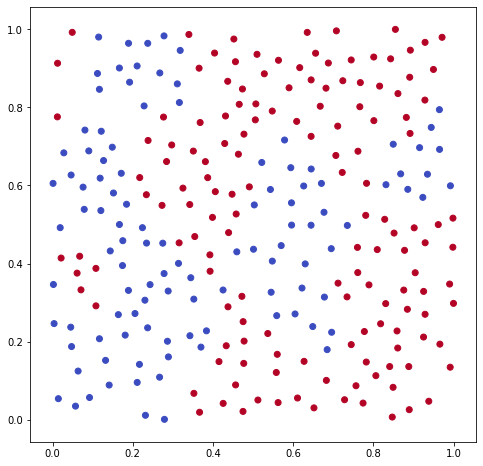

In [4]:
# 1) Build a dataset and display it 
dataset_params = dl.RandomKParameters(256, 30, radius=0.02)
dataset = dl.Random2DBinaryDataset(dataset_params, random_seed=420)
train_data, val_data = dataset.split_train_val(1.0)
dataset.plot_2d()

In [5]:
# 2) Build neural net and train it 
test_net = ReLUNet(layer_sizes=[2, 16, 32, 64, 16, 2])
train_params = train.TrainParameters(train_data, train_data, 1000, test_after_epoch=100)
train.training_loop(test_net, train_params)

Epoch 00 | Accuracy: 42.58
Epoch 100 | Accuracy: 75.78
Epoch 200 | Accuracy: 75.00
Epoch 300 | Accuracy: 92.19
Epoch 400 | Accuracy: 96.88
Epoch 500 | Accuracy: 97.27
Epoch 600 | Accuracy: 97.27
Epoch 700 | Accuracy: 97.66
Epoch 800 | Accuracy: 98.05
Epoch 900 | Accuracy: 98.05


In [6]:
# 3) Run single evaluations for a particular hyperbox and multiple types of results
hbox1 = Hyperbox.build_linf_ball(np.array([0.5, 0.5]), 0.2)
c_vec = torch.Tensor([1.0, -1.0])
local_args = {'network': test_net, 'domain': hbox1, 'c_vector': c_vec, 'primal_norm': 'linf'}

In [7]:
# 3.1) lipMIP
lip_prob = LipProblem(test_net, hbox1, c_vec, verbose=True, num_threads=4)
lip_prob.compute_max_lipschitz()
lip_prob.result

Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (linux64)
Optimize a model with 1046 rows, 614 columns and 9280 nonzeros
Model fingerprint: 0x824aee9f
Variable types: 522 continuous, 92 integer (92 binary)
Coefficient statistics:
  Matrix range     [3e-05, 6e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-08, 3e+03]
  RHS range        [1e-08, 6e+03]
Presolve removed 359 rows and 181 columns
Presolve time: 0.07s
Presolved: 687 rows, 433 columns, 7136 nonzeros
Variable types: 356 continuous, 77 integer (77 binary)

Root relaxation: objective 2.790220e+03, 575 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2770.91588    0   54          - 2770.91588      -     -    0s
     0     0 2750.69610    0   61          - 2750.69610      -     -    0s
H    0     0  

LipMIP Result: 
	Value 354.712
	Runtime 0.786

In [8]:
# 3.2) CLEVER
clever = CLEVER(**local_args)
clever.compute()

354.7120666503906

In [9]:
# 3.3) FastLip
fastlip = FastLip(**local_args)
fastlip.compute()

4680.738

In [10]:
# 3.4) LipLP
liplp = LipLP(**local_args)
liplp.compute()

4418.351108605412

In [11]:
# 3.5) LipSDP
lipsdp = LipSDP(test_net, c_vec)
lipsdp.compute()
print(lipsdp.l1_value())

1941.1770552806809


In [12]:
# 3.6) Naive UB
naiveub = NaiveUB(test_net, c_vec, 'linf')
print("L1 norms of matrices:", naiveub.compute())
naiveub2 = NaiveUB(test_net, c_vec, 'l2')
print("L2 norms of matrices, scaled by sqrt(2)", naiveub2.compute() * 2**0.5)



L1 norms of matrices: 32390.244
L2 norms of matrices, scaled by sqrt(2) 27052.201210369218


In [13]:
# 3.7) Random LB
randomlb = RandomLB(**local_args)
randomlb.compute()

tensor(354.7120)

In [14]:
# 3.8) SeqLip
seqlip = SeqLip(**local_args)
seqlip.compute() * 2 **0.5 


../other_methods/seq_lip.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c_vec = torch.tensor(self.c_vector).view(1, -1)


3162.988943009787

In [15]:
# 4) Run some simple experimental series
exp_1 = Experiment([RandomLB, FastLip, LipProblem], network=test_net, c_vector=c_vec, 
                   primal_norm='linf', verbose=False, num_threads=4)


In [ ]:
# 4.1) Evaluate over the unit hypercube
hypercube_result = exp_1.do_unit_hypercube_eval()
print(hypercube_result.values())


In [ ]:
# 4.2) Evaluate over random Linf balls of radius 0.2
ball_factory = Factory(Hyperbox.build_linf_ball, radius=0.2, global_lo=np.array([0,0]), global_hi=np.array([1.0, 1.0]))
center_domain = Hyperbox.build_linf_ball(x=np.array([0.5, 0.5]), radius=0.5)
random_results = exp_1.do_random_evals(10, center_domain, ball_factory)
random_results.average_stdevs('value')


In [ ]:
# 4.3) Evaluate over random data points 
data_results = exp_1.do_data_evals(train_data[0][0], ball_factory, num_random=10)
data_results.average_stdevs('value')